In [4]:
import matplotlib.pyplot as plt 
plt.style.use('fast')
from pyFTS.partitioners import Grid, CMeans, Entropy
from pyFTS.common import Util as cUtil
from pyFTS.models import hofts,pwfts
from pyFTS.models.multivariate import mvfts, wmvfts, granular, variable
from pyFTS.benchmarks import Measures
from pyFTS.common import Transformations
from pyFTS.models.seasonal import partitioner as seasonal
from pyFTS.models.seasonal.common import DateTime
from pyFTS.common import Membership
import pandas as pd

In [5]:
def init ():
    Dataset = pd.read_csv('./PJME_hourly.csv')
    Dataset.Datetime = pd.to_datetime(Dataset.Datetime)
    Dataset.set_index('Datetime', inplace = True)
    Dataset.rename(columns={'PJME_MW': 'demand'}, inplace=True)
    Dataset = Dataset.resample('H').mean()
    return Dataset

In [2]:
def handleModel(train_set,model):
    plt.figure()
    plt.plot(train_set)
    modelX = cUtil.load_obj(model.name)
    forecasts = modelX.predict(train_set)
    plt.plot(forecasts)
    plt.title(model.name)
    plt.tight_layout()

def createModels(models,train_set,test_set,df):
    for model in models:
        model.fit(train_set, save_model=True, file_path=model.name)
        result = Measures.get_point_statistics(test_set, model)
        dictResult= {   'Name': model.name,
                        'RMSE': result[0],
                        'SMAPE': result[1],
                        'Theils U': result[2]
                    }
        df = df.append(dictResult,ignore_index=True)
        handleModel(model=model, train_set=train_set)
    return df

In [31]:
Dataset = init()
Dataset['weekday'] = Dataset.index.day_name()
Dataset['hour'] = Dataset.index.hour
Dataset = Dataset.resample('D').mean()
Dataset['weekday'] = Dataset.index.day_name()
Dataset.drop(['hour','weekday'],axis=1,inplace=True)
Dataset.reset_index(inplace=True)

train_size = int(len(Dataset)*2/3)
train_set_pd = Dataset[:train_size]
test_set_pd = Dataset[train_size:]

/tmp/ipykernel_163024/3489156429.py:4: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  Dataset = Dataset.resample('D').mean()


In [32]:
train_set = train_set_pd.demand.to_list()
test_set = test_set_pd.demand.to_list()
data = Dataset['demand'].values
print(train_set_pd.head())

    Datetime        demand
0 2002-01-01  31080.739130
1 2002-01-02  34261.541667
2 2002-01-03  34511.875000
3 2002-01-04  33715.458333
4 2002-01-05  30405.125000


/home/cesar/.local/lib/python3.10/site-packages/pyFTS/models/seasonal/partitioner.py:200: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.xaxis.set_ticklabels(ticks)
/home/cesar/.local/lib/python3.10/site-packages/pyFTS/partitioners/partitioner.py:238: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.xaxis.set_ticklabels(ticks)


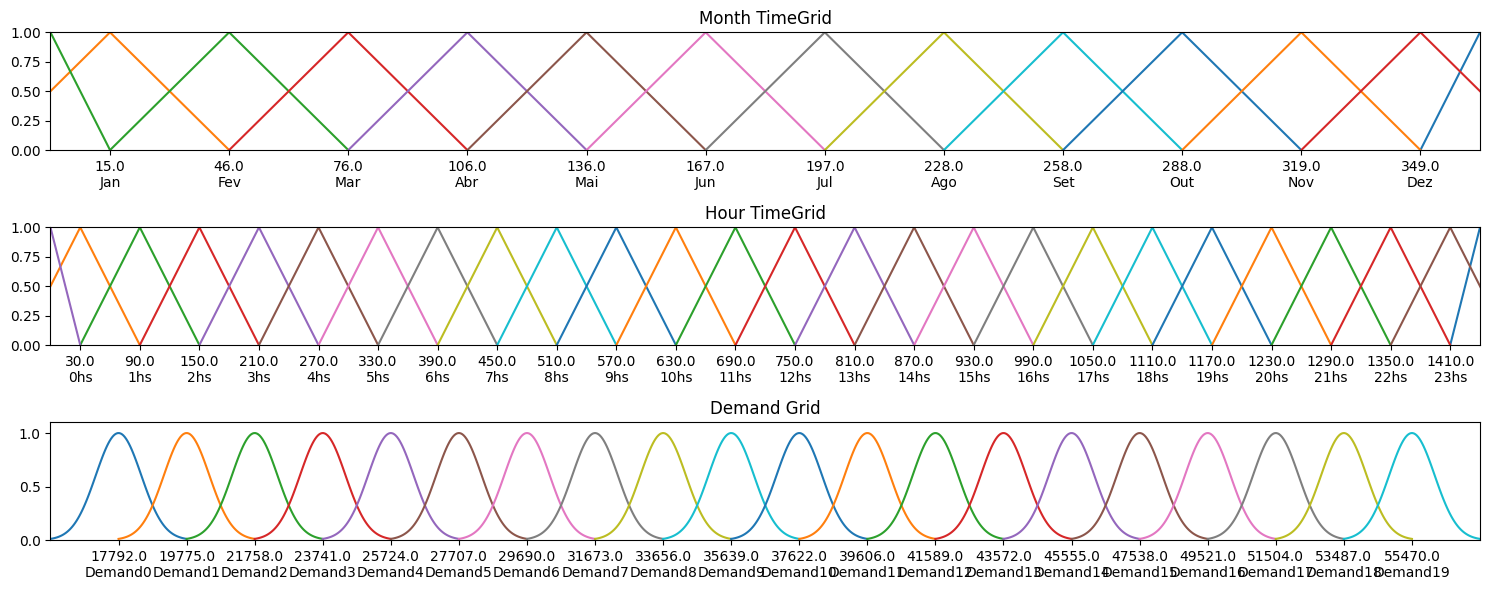

In [35]:
fig, ax = plt.subplots(nrows=3, ncols=1, figsize=[15,6])

sp = {'seasonality': DateTime.day_of_year , 
      'names': ['Jan','Fev','Mar','Abr','Mai','Jun','Jul', 'Ago','Set','Out','Nov','Dez']}

vmonth = variable.Variable("Month", data_label="Datetime", 
                        partitioner=seasonal.TimeGridPartitioner, npart=12, 
                        data=train_set_pd, partitioner_specific=sp)
vmonth.partitioner.plot(ax[0])

sp = {'seasonality': DateTime.minute_of_day, 'names': [str(k)+'hs' for k in range(0,24)]}

vhour = variable.Variable("Hour", data_label="Datetime", 
                        partitioner=seasonal.TimeGridPartitioner, npart=24, 
                        data=train_set_pd, partitioner_specific=sp)
vhour.partitioner.plot(ax[1])

vload = variable.Variable("Demand", data_label="demand",
                        partitioner=Grid.GridPartitioner, npart=20, 
                        func=Membership.gaussmf, 
                        data=train_set_pd)
vload.partitioner.plot(ax[2])
plt.tight_layout()

In [45]:
error_df = pd.DataFrame(columns = ["Name","RMSE","SMAPE","Theils U"])

models = []

model = mvfts.MVFTS(explanatory_variables=[vmonth, vhour, vload], target_variable=vload)
model.name='MVFTS'
models.append(model)

model = wmvfts.WeightedMVFTS(explanatory_variables=[vmonth, vhour, vload], target_variable=vload)
model.name='WMVFTS'
models.append(model)

model = granular.GranularWMVFTS(explanatory_variables=[vmonth, vhour, vload], target_variable=vload, 
                                order=18,
                                knn=2, 
                                fts_method=pwfts.ProbabilisticWeightedFTS, 
                                fuzzyfy_mode='both')
model.name='GranularWMWFTS'
models.append(model)

In [46]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=[15,3])

ax.plot(test_set_pd['demand'].values[:48],label='Original')

rows = []

for ct, model in enumerate(models):

  model.fit(train_set_pd)

  forecasts = model.predict(test_set_pd.iloc[:48])

  if model.is_high_order:
    for k in range(model.order):
      forecasts.insert(0,None)
  ax.plot(forecasts[:48], label=model.shortname)
  rmse, mape, u = Measures.get_point_statistics(test_set_pd, model)

  rows.append([model.name, rmse, mape, u])


handles, labels = ax.get_legend_handles_labels()
lgd = ax.legend(handles, labels, loc=2, bbox_to_anchor=(1, 1))

pd.DataFrame(rows, columns=['Model','RMSE','sMAPE','U'])

: 